# Introduction




# Prepare for analysis

## Load packages

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from load_data import load_data
from load_data import combine_train_test

from study_data import missing_data
from study_data import most_frequent_data
from study_data import unique_values
from study_data import unique_values_summary

from clean_data import add_family_size, add_age_interval, add_fare_interval_column, add_sex_pclass
from clean_data import extract_names, parse_names, add_family_type_column, assign_family_type
from clean_data import unify_titles, calculate_survival_rate_by_title_and_sex, map_sex_column

import ML


In [2]:
# TODO: Add all hard coded parameters like file paths or model parameters here
TRAIN_PATH = "../data/train.csv"
TEST_PATH = "../data/test.csv"

## Read the data

In [3]:
train_df = load_data(TRAIN_PATH)
test_df = load_data(TEST_PATH)
# TODO: Put the path at the top of the script and replace with variable
 

# Preliminary data inspection

## Quick glimpse of the data
Comment out as needed.

In [4]:

# train_df.head()
# test_df.head()

# train_df.info()
# test_df.info()

# train_df.describe()
# test_df.describe()

## Few statistics on the data

### Missing data

In [6]:
## Missing training data
missing_data(train_df)


,Total,Percent,Types
PassengerId,0,0.000000,int64
Survived,0,0.000000,int64
Pclass,0,0.000000,int64
Name,0,0.000000,object
Sex,0,0.000000,object
Age,177,19.865320,float64
SibSp,0,0.000000,int64
Parch,0,0.000000,int64
Ticket,0,0.000000,object
Fare,0,0.000000,float64


In [7]:
# Missing test data
missing_data(test_df)

,Total,Percent,Types
PassengerId,0,0.000000,int64
Pclass,0,0.000000,int64
Name,0,0.000000,object
Sex,0,0.000000,object
Age,86,20.574163,float64
SibSp,0,0.000000,int64
Parch,0,0.000000,int64
Ticket,0,0.000000,object
Fare,1,0.239234,float64
Cabin,327,78.229665,object


### Most frequent data

Training Data

In [8]:
most_frequent_data(train_df)

,Total,Most frequent item,Frequence,Percent from total
PassengerId,891,1,1,0.112
Survived,891,0,549,61.616
Pclass,891,3,491,55.107
Name,891,"Braund, Mr. Owen Harris",1,0.112
Sex,891,male,577,64.759
Age,714,24.0,30,4.202
SibSp,891,0,608,68.238
Parch,891,0,678,76.094
Ticket,891,347082,7,0.786
Fare,891,8.05,43,4.826


Testing Data

In [9]:
most_frequent_data(test_df)

,Total,Most frequent item,Frequence,Percent from total
PassengerId,418,892,1,0.239
Pclass,418,3,218,52.153
Name,418,"Kelly, Mr. James",1,0.239
Sex,418,male,266,63.636
Age,332,21.0,17,5.120
SibSp,418,0,283,67.703
Parch,418,0,324,77.512
Ticket,418,PC 17608,5,1.196
Fare,417,7.75,21,5.036
Cabin,91,B57 B59 B63 B66,3,3.297


### Unique values

Training Data

In [10]:
unique_values_summary(train_df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Total,891,891,891,891,891,714,891,891,891,891,204,889
Uniques,891,2,3,891,2,88,7,7,681,248,147,3


Testing Data

In [11]:
unique_values_summary(test_df)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Total,418,418,418,418,332,418,418,418,417,91,418
Uniques,418,3,418,2,79,7,8,363,169,76,3


# Exploratory data analysis

## Univariate analysis for all features


We show here two graphs in paralel:
* distribution of class values, split per Survived value
* comparison of class values, in train and test data


Let's first aggregate train and test data into one single dataframe, `all_df`.

In [25]:
all_df = combine_train_test(train_df, test_df, "Survived")
print(all_df.head())

   PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked    set  
0      0         A/5 21171   7.2500   NaN        S  train  
1      0          PC 17599  71.2833   C85        C  train  
2      0  STON/O2. 3101282   7.9250   NaN        S  train  
3      0            113803  53.1000  C123        S  train  
4      0            

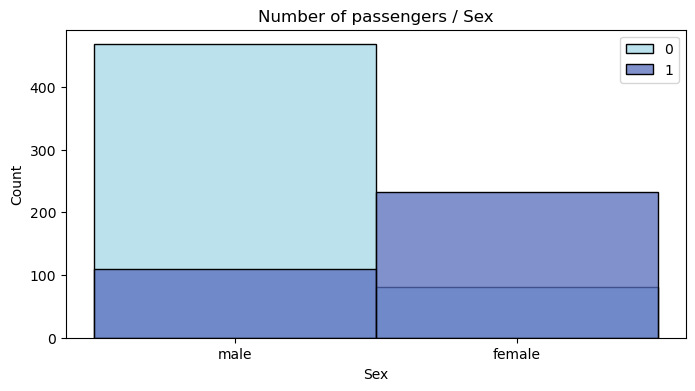

In [14]:
# Plot distribution pairs for "Sex" and hue as "Survived"
color_list = ["#A5D7E8", "#576CBC", "#19376D", "#0b2447"]
f, ax = plt.subplots(1, 1, figsize=(8, 4))
for i, h in enumerate(train_df["Survived"].unique()):
    g = sns.histplot(train_df.loc[train_df["Survived"]==h, "Sex"], 
                                  color=color_list[i], 
                                  ax=ax, 
                                  label=h)
ax.set_title("Number of passengers / Sex")
g.legend()
plt.savefig("../figures/number of passengers by sex and survived (train).png")
plt.show()

In [45]:
def plot_count_pairs(df, feature, title, data_type, hue="set"):
    f, ax = plt.subplots(1, 1, figsize=(8, 4))
    sns.countplot(x=feature, data=df, hue=hue, palette= color_list)
    plt.grid(color="black", linestyle="-.", linewidth=0.5, axis="y", which="major")
    ax.set_title(f"Number of passengers / {title}({data_type})")
    filename = f"../figures/count_by_{title}_{data_type}.png"
    plt.savefig(filename)
    plt.show()

In [31]:
def plot_distribution_pairs(data_df, feature, title, data_type, hue="set"):
    f, ax = plt.subplots(1, 1, figsize=(8, 4))
    for i, h in enumerate(data_df[hue].unique()):
        g = sns.histplot(data_df.loc[data_df[hue]==h, feature], color=color_list[i], ax=ax, label=h)
    ax.set_title(f"Number of passengers / {title}{data_type}")
    g.legend()
    filename = f"../figures/dist_by_{feature}_{data_type}.png"
    plt.savefig(filename)
    plt.show()  

/var/folders/bk/b8ffntf144l62w04yddn0vt40000gn/T/ipykernel_25278/2719148997.py:3: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=feature, data=df, hue=hue, palette= color_list)


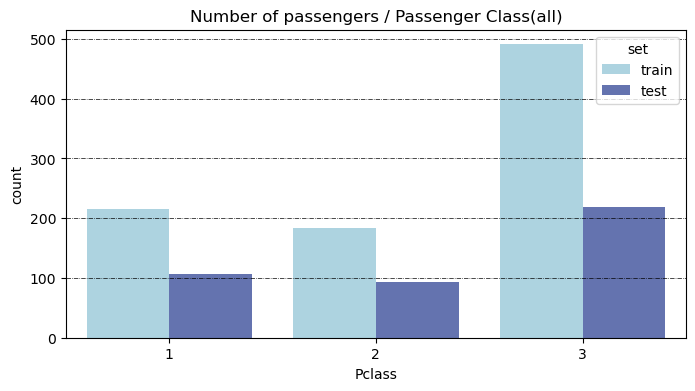

In [16]:
plot_count_pairs(all_df,  "Pclass", "Passenger Class", data_type='all')

/var/folders/bk/b8ffntf144l62w04yddn0vt40000gn/T/ipykernel_25278/2719148997.py:3: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=feature, data=df, hue=hue, palette= color_list)


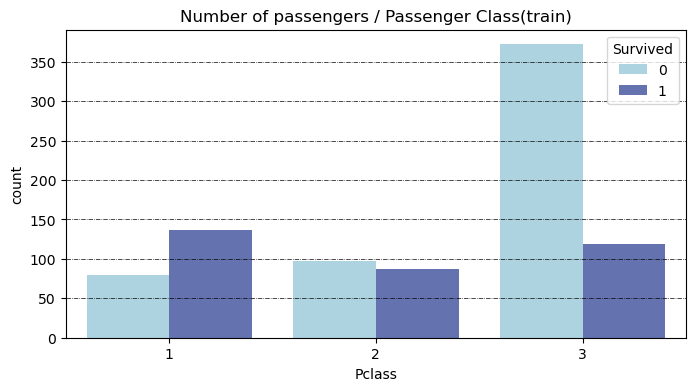

In [17]:
plot_count_pairs(train_df,  "Pclass", "Passenger Class", data_type='train', hue = 'Survived')

/var/folders/bk/b8ffntf144l62w04yddn0vt40000gn/T/ipykernel_25278/2719148997.py:3: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=feature, data=df, hue=hue, palette= color_list)


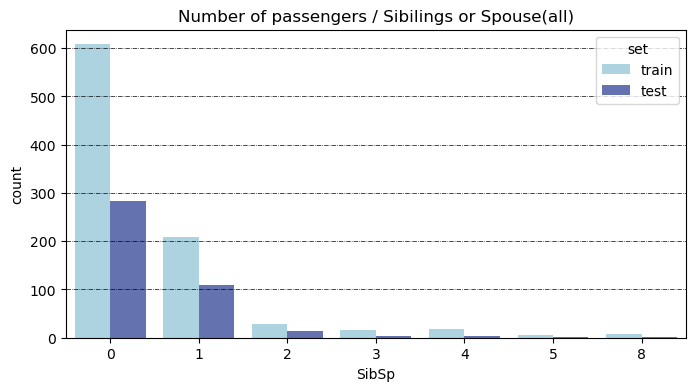

In [18]:
plot_count_pairs(all_df,  "SibSp", "Sibilings or Spouse", data_type='all')


/var/folders/bk/b8ffntf144l62w04yddn0vt40000gn/T/ipykernel_25278/2719148997.py:3: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=feature, data=df, hue=hue, palette= color_list)


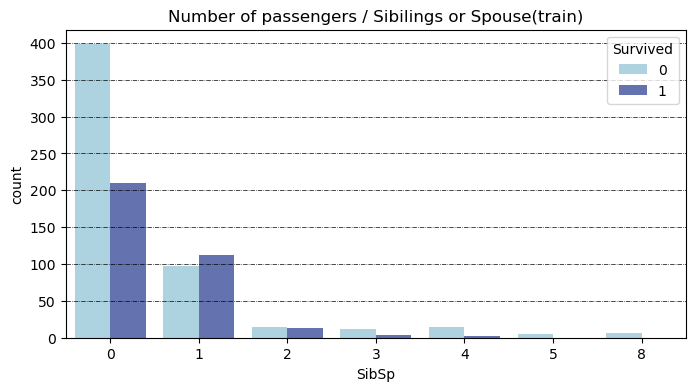

In [19]:
plot_count_pairs(train_df,  "SibSp", "Sibilings or Spouse", data_type='train', hue = 'Survived')

/var/folders/bk/b8ffntf144l62w04yddn0vt40000gn/T/ipykernel_25278/2719148997.py:3: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=feature, data=df, hue=hue, palette= color_list)


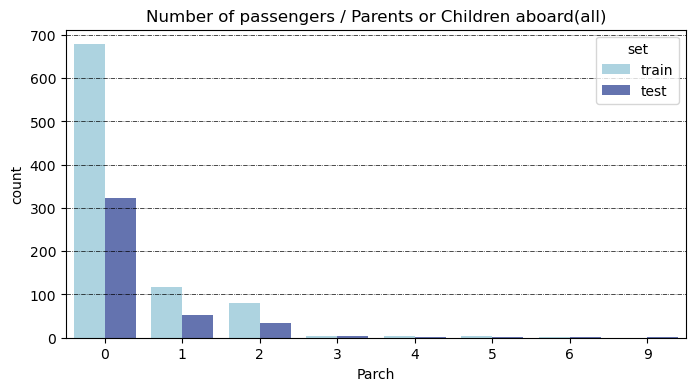

In [32]:
plot_count_pairs(all_df,  "Parch", "Parents or Children aboard", data_type='all')

/var/folders/bk/b8ffntf144l62w04yddn0vt40000gn/T/ipykernel_25278/2719148997.py:3: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=feature, data=df, hue=hue, palette= color_list)


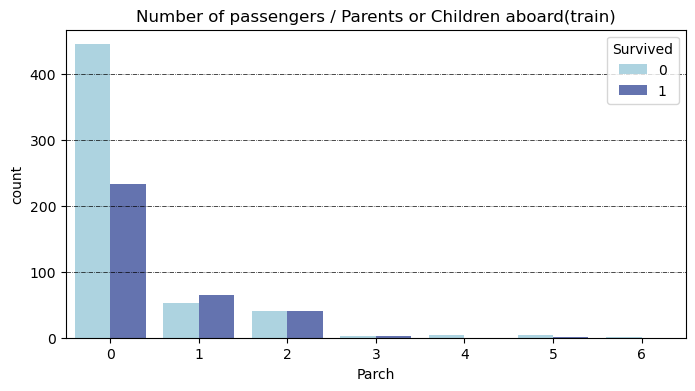

In [21]:
plot_count_pairs(train_df,  "Parch", "Parents or Children aboard",data_type='train', hue = 'Survived')

/var/folders/bk/b8ffntf144l62w04yddn0vt40000gn/T/ipykernel_25278/2719148997.py:3: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=feature, data=df, hue=hue, palette= color_list)


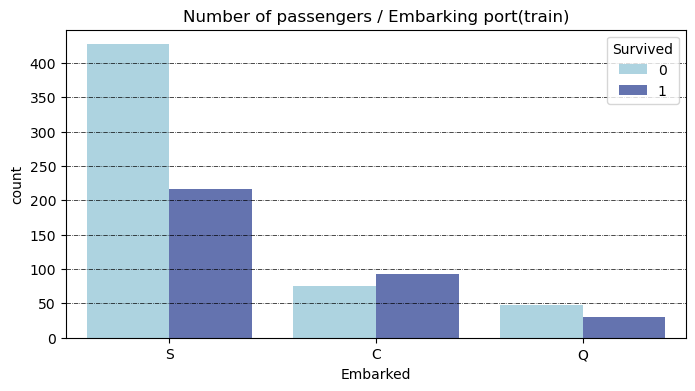

In [22]:
plot_count_pairs(train_df,  "Embarked", "Embarking port", data_type='train', hue = "Survived")

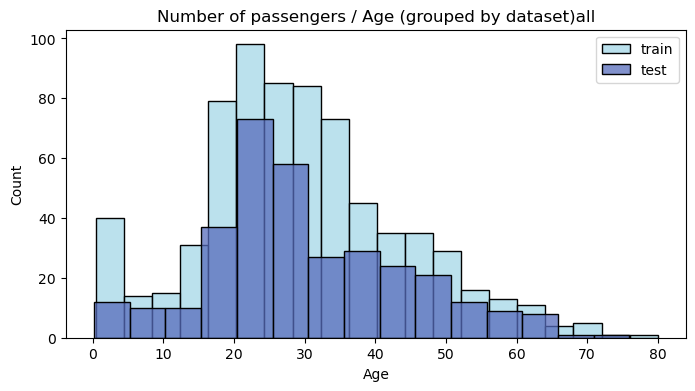

In [33]:
plot_distribution_pairs(all_df, "Age", "Age (grouped by dataset)", data_type= 'all')

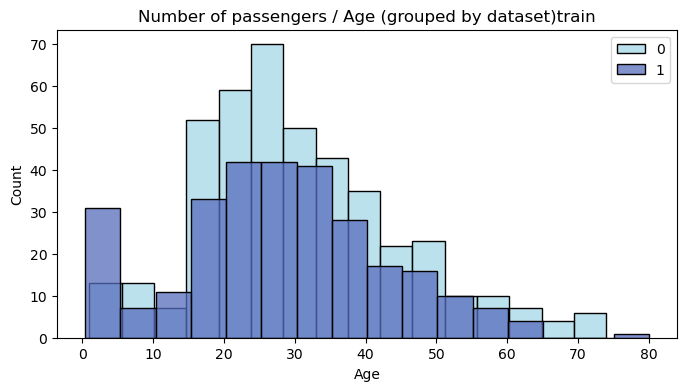

In [34]:
plot_distribution_pairs(train_df, "Age", "Age (grouped by dataset)", data_type= 'train', hue ="Survived")

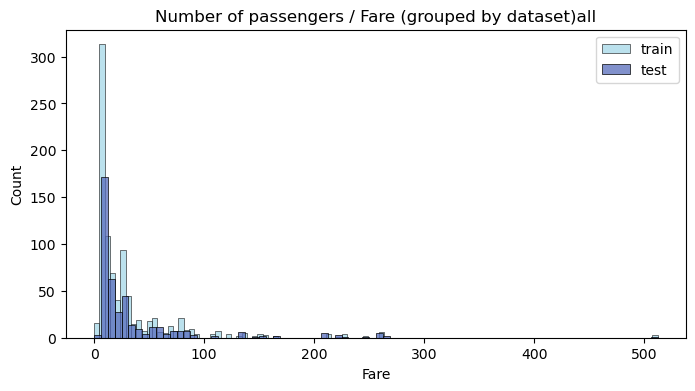

In [46]:
plot_distribution_pairs(all_df, "Fare", "Fare (grouped by dataset)", data_type = 'all')

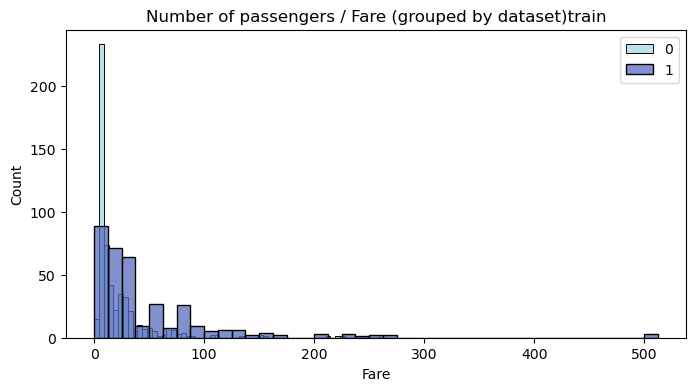

In [37]:
plot_distribution_pairs(train_df, "Fare", "Fare (grouped by dataset)", data_type = 'train', hue = "Survived")

## Family size


Based on SibSp (sibilings or spouse) and Parch (parents or children), we set the Family Size field.

In [39]:
all_df = add_family_size(all_df)
train_df = add_family_size(train_df)
test_df = add_family_size(test_df)


/var/folders/bk/b8ffntf144l62w04yddn0vt40000gn/T/ipykernel_25278/1489166949.py:3: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=feature, data=df, hue=hue, palette= color_list)


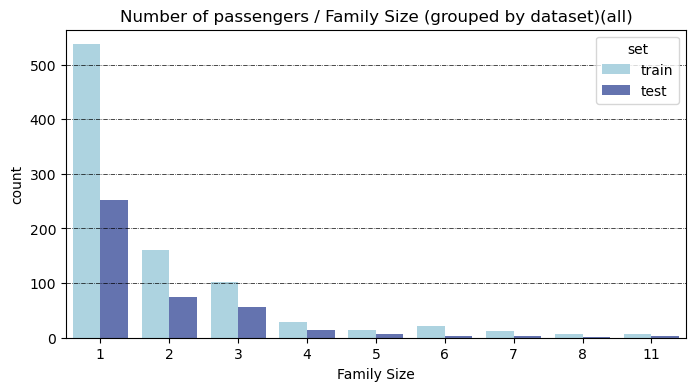

In [47]:
plot_count_pairs(all_df, "Family Size", "Family Size (grouped by dataset)", data_type='all')

/var/folders/bk/b8ffntf144l62w04yddn0vt40000gn/T/ipykernel_25278/1489166949.py:3: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=feature, data=df, hue=hue, palette= color_list)


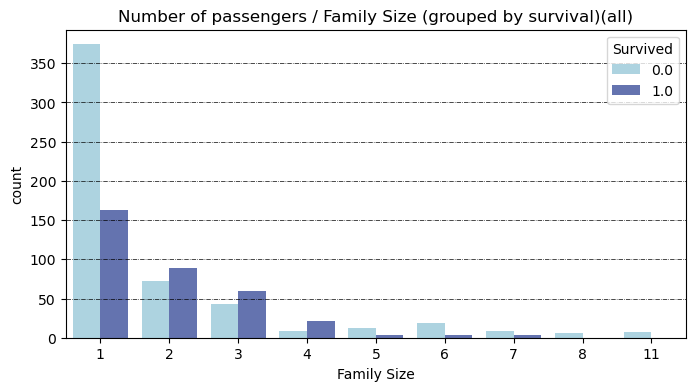

In [48]:
plot_count_pairs(all_df, "Family Size", "Family Size (grouped by survival)", data_type='all', hue = "Survived")

## Age interval

In [49]:

all_df = add_age_interval(all_df)
train_df = add_age_interval(train_df)
test_df = add_age_interval(test_df)


/var/folders/bk/b8ffntf144l62w04yddn0vt40000gn/T/ipykernel_25278/1489166949.py:3: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=feature, data=df, hue=hue, palette= color_list)


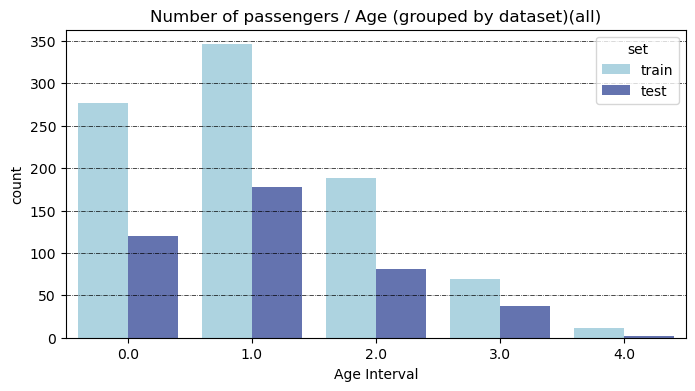

In [50]:
plot_count_pairs(all_df, "Age Interval", "Age (grouped by dataset)", data_type ='all')

/var/folders/bk/b8ffntf144l62w04yddn0vt40000gn/T/ipykernel_25278/1489166949.py:3: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=feature, data=df, hue=hue, palette= color_list)


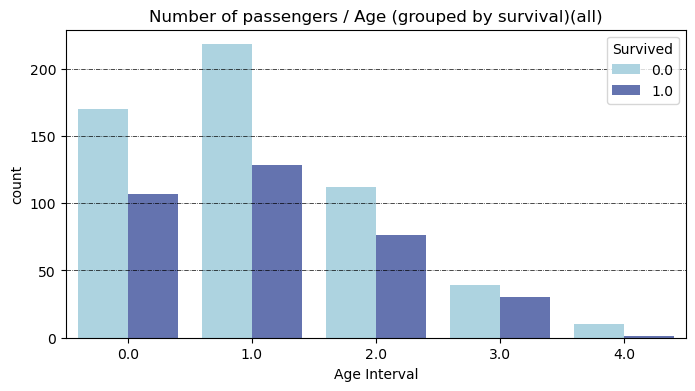

In [51]:
plot_count_pairs(all_df, "Age Interval", "Age (grouped by survival)", data_type ='all', hue = "Survived")

## Fare interval

In [52]:
all_df = add_fare_interval_column(all_df)
train_df = add_fare_interval_column(train_df)
test_df = add_fare_interval_column(test_df)

/var/folders/bk/b8ffntf144l62w04yddn0vt40000gn/T/ipykernel_25278/1489166949.py:3: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=feature, data=df, hue=hue, palette= color_list)


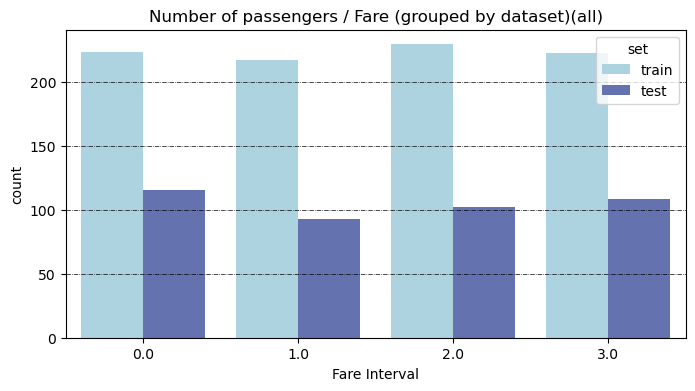

In [53]:
plot_count_pairs(all_df, "Fare Interval", "Fare (grouped by dataset)", data_type= 'all')

/var/folders/bk/b8ffntf144l62w04yddn0vt40000gn/T/ipykernel_25278/1489166949.py:3: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=feature, data=df, hue=hue, palette= color_list)


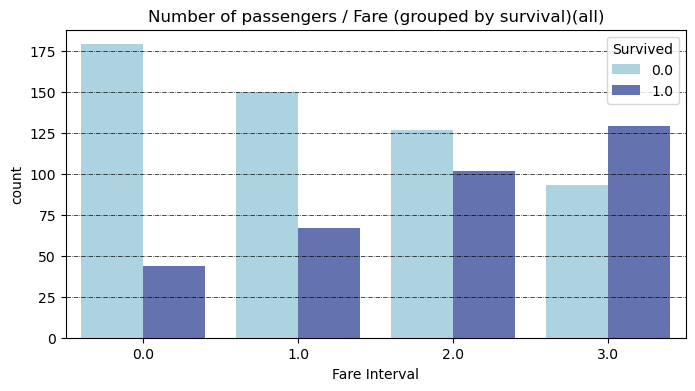

In [54]:
plot_count_pairs(all_df, "Fare Interval", "Fare (grouped by survival)", data_type= 'all', hue = "Survived")

## P-class + Sex

In [55]:
all_df = add_sex_pclass(all_df)
train_df = add_sex_pclass(train_df)
test_df = add_sex_pclass(test_df)

## Process names


When we process names, we would like to extract the following information:

- Family name - this is the first word (or few first words, if a family name with multiple names), followed by a comma  
- Title - this follows just after the comma   
- Given name - this is the word or group of words following family name  
- Maiden name - for ladies, is given between parantheses  

We start with creating a function that parses the Name string and extract (if possible) these 4 elements


In [29]:
all_df = extract_names(all_df)
train_df = extract_names(train_df)
test_df = extract_names(test_df)

## Multivariate analysis


Let's look now to the interaction of multiple features.

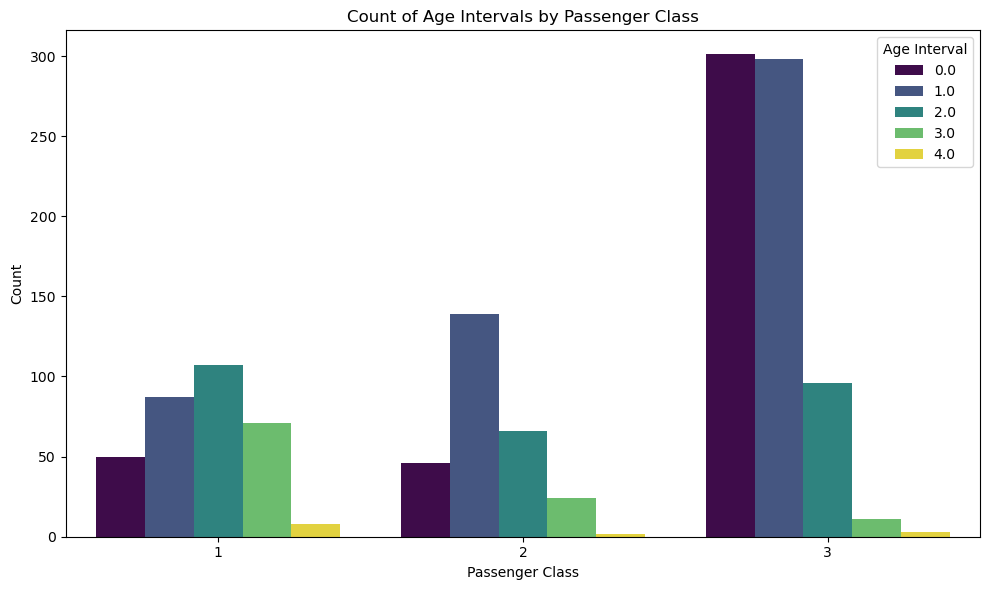

In [56]:
# TODO: Plot count pairs of "Age Interval" grouped by "Pclass"
def plot_age_interval_by_pclass(df):
    """
    Plot count of 'Age Interval' grouped by 'Pclass'.

    Parameters:
    df (pd.DataFrame): The DataFrame containing 'Age Interval' and 'Pclass' columns.
    """
    # Group by 'Pclass' and 'Age Interval' and count occurrences
    count_data = df.groupby(['Pclass', 'Age Interval']).size().reset_index(name='Count')

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Pclass', y='Count', hue='Age Interval', data=count_data, palette='viridis')
    
    # Adding title and labels
    plt.title('Count of Age Intervals by Passenger Class')
    plt.xlabel('Passenger Class')
    plt.ylabel('Count')
    plt.legend(title='Age Interval')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig("../figures/Count of Age Intervals by Passenger Class.png")
    plt.show()

plot_age_interval_by_pclass(all_df)

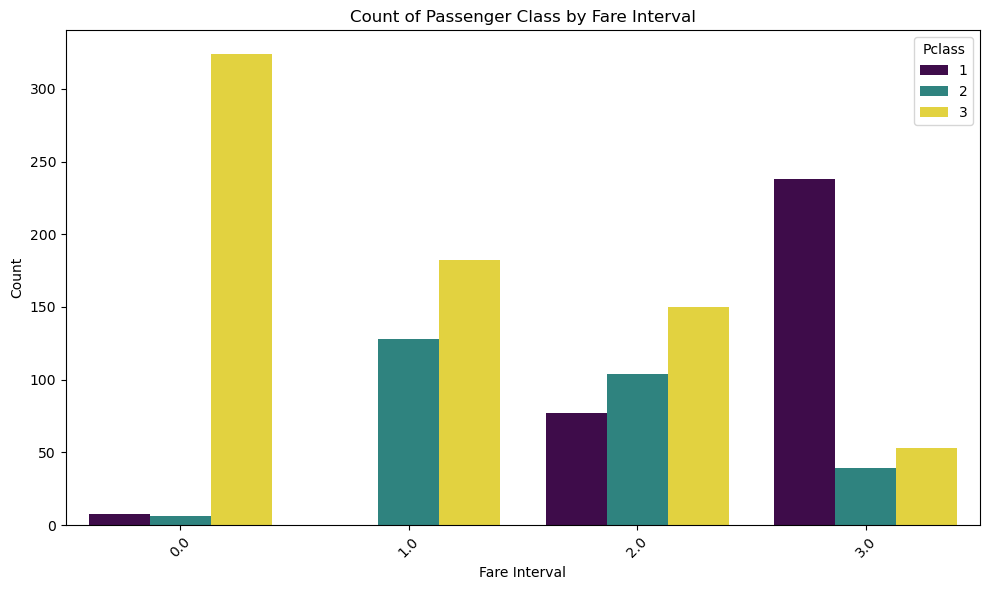

In [57]:
# TODO: Plot count pairs of "Pclass" grouped by "Fare Interval"

def plot_pclass_by_fare_interval(df):
    """
    Plot count of 'Pclass' grouped by 'Fare Interval'.

    Parameters:
    df (pd.DataFrame): The DataFrame containing 'Pclass' and 'Fare Interval' columns.
    """
    # Group by 'Fare Interval' and 'Pclass' and count occurrences
    count_data = df.groupby(['Fare Interval', 'Pclass']).size().reset_index(name='Count')

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Fare Interval', y='Count', hue='Pclass', data=count_data, palette='viridis')
    
    # Adding title and labels
    plt.title('Count of Passenger Class by Fare Interval')
    plt.xlabel('Fare Interval')
    plt.ylabel('Count')
    plt.legend(title='Pclass')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("../figures/Count pairs of Pclass grouped by Fare Interval.png")
    plt.show()
plot_pclass_by_fare_interval(all_df)

### Few more engineered data 


Let's create two more engineered features:  
* Family size interval: Single, Small, Large  
* Aggregated titles: Mr, Mrs, Master, Miss, and Rare  

In [35]:
add_family_type_column([all_df, train_df, test_df])

In [36]:
assign_family_type([all_df, train_df, test_df])

/Users/rachely/titanic_problem_set/Modules/clean_data.py:149: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Single' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[dataset["Family Size"] == 1, "Family Type"] = "Single"
/Users/rachely/titanic_problem_set/Modules/clean_data.py:149: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Single' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[dataset["Family Size"] == 1, "Family Type"] = "Single"
/Users/rachely/titanic_problem_set/Modules/clean_data.py:149: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Single' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  da

In [37]:
for dataset in [all_df, train_df, test_df]:
    dataset["Titles"] = dataset["Title"]

In [38]:
all_datasets = [all_df, train_df, test_df]

In [39]:
all_df["Survived"]

0      0.0
1      1.0
2      1.0
3      1.0
4      0.0
      ... 
413    NaN
414    NaN
415    NaN
416    NaN
417    NaN
Name: Survived, Length: 1309, dtype: float64

In [40]:
def calculate_survival_rate_by_title_and_sex(dataset):
    """
    Calculate the mean survival rate grouped by 'Titles' and 'Sex'.

    Parameters:
    dataset (pd.DataFrame): The DataFrame containing the relevant columns.

    Returns:
    pd.DataFrame: A DataFrame with the mean survival rates grouped by 'Titles' and 'Sex'.
    """
    return dataset[['Titles', 'Sex', 'Survived']].groupby(['Titles', 'Sex'], as_index=False).mean()

calculate_survival_rate_by_title_and_sex(all_df)

,Titles,Sex,Survived
0,Capt.,male,0.000000
1,Col.,male,0.500000
2,Don.,male,0.000000
3,Dona.,female,NaN
4,Dr.,female,1.000000
5,Dr.,male,0.333333
6,Jonkheer.,male,0.000000
7,Lady.,female,1.000000
8,Major.,male,0.500000
9,Master.,male,0.575000


In [41]:
calculate_survival_rate_by_title_and_sex(train_df)

,Titles,Sex,Survived
0,Capt.,male,0.000000
1,Col.,male,0.500000
2,Don.,male,0.000000
3,Dr.,female,1.000000
4,Dr.,male,0.333333
5,Jonkheer.,male,0.000000
6,Lady.,female,1.000000
7,Major.,male,0.500000
8,Master.,male,0.575000
9,Miss.,female,0.697802


In [45]:
unify_titles(all_datasets)
#calculate_survival_rate_by_title_and_sex(all_datasets)
map_sex_column(all_datasets)

# Baseline model

## Feature engineering: Map categorical value to numerical values

Create train-validation split.

In [46]:
VALID_SIZE = 0.2
train, valid = train_test_split(train_df, test_size=VALID_SIZE, random_state=42, shuffle=True)

Define predictor features and target feature.

In [47]:
predictors = ["Sex", "Pclass"]
target = 'Survived'

Define the training and validation data and labels.

In [48]:
# TODO: prepare_datasets

train_X = ML.prepare_datasets(train=train, valid=valid, predictors=predictors, target=target)[0]
train_Y = ML.prepare_datasets(train=train, valid=valid, predictors=predictors, target=target)[1]
valid_X = ML.prepare_datasets(train=train, valid=valid, predictors=predictors, target=target)[2]
valid_Y = ML.prepare_datasets(train=train, valid=valid, predictors=predictors, target=target)[3]


Initialize the classifiction algorithm.

In [49]:
# TODO: train_and_predict_random_forest

preds_train = ML.train_and_predict_random_forest(train_X=train_X, train_Y=train_Y, valid_X=valid_X, random_state=42, n_estimators=100, criterion="gini")[0]
preds_valid = ML.train_and_predict_random_forest(train_X=train_X, train_Y=train_Y, valid_X=valid_X, random_state=42, n_estimators=100, criterion="gini")[1]

Fit the classifier with the training data.

Predict the train data (to check the training classification error).

Predict the validation data.

# Evaluation

## Classification report for training data.

In [50]:
print(metrics.classification_report(train_Y, preds_train, target_names=['Not Survived', 'Survived']))

              precision    recall  f1-score   support

Not Survived       0.75      0.99      0.86       444
    Survived       0.96      0.47      0.63       268

    accuracy                           0.79       712
   macro avg       0.86      0.73      0.74       712
weighted avg       0.83      0.79      0.77       712



Classification report for validation data.

In [51]:
print(metrics.classification_report(valid_Y, preds_valid, target_names=['Not Survived', 'Survived']))

              precision    recall  f1-score   support

Not Survived       0.73      0.96      0.83       105
    Survived       0.90      0.49      0.63        74

    accuracy                           0.77       179
   macro avg       0.81      0.72      0.73       179
weighted avg       0.80      0.77      0.75       179

